# Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import math
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import os

# Modèle

In [2]:
# Définition des classes du modèle (comme dans votre code)
class Generator(nn.Module):
    def __init__(self, seq_len=64, patch_size=24, channels=1, num_classes=9, latent_dim=100, embed_dim=10, depth=3,
                 num_heads=5, forward_drop_rate=0.5, attn_drop_rate=0.5):
        super(Generator, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate

        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
            depth=self.depth,
            emb_size=self.embed_dim,
            drop_p=self.attn_drop_rate,
            forward_drop_p=self.forward_drop_rate
        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0)
        )

    def forward(self, z):
        x = self.l1(z).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        return output


class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=1):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out


class PatchEmbedding_Linear(nn.Module):
    def __init__(self, in_channels=1, patch_size=16, emb_size=100, seq_length=1024):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=1, s2=patch_size),
            nn.Linear(patch_size * in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x


class Discriminator(nn.Sequential):
    def __init__(self,
                 in_channels=1,
                 patch_size=24,
                 emb_size=50,
                 seq_length=24,
                 depth=3,
                 n_classes=1,
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

# Génération Data

In [3]:
# Fonctions pour générer des sinusoïdes
def generate_random_sine_wave(num_points=1000):
    frequency = np.random.uniform(np.pi/2, np.pi)
    amplitude = np.random.uniform(0.2, 1)
    phase = np.random.uniform(0, 2 * np.pi)
    x = np.linspace(0, 4 * np.pi, num_points)
    y = amplitude * np.sin(frequency * x + phase)
    return x, y

# Fonction pour tester le fonctionnement du générateur
def generate_constant_wave(num_points=1000):
    value = np.random.uniform(-1, 1)
    x = np.linspace(0, 4 * np.pi, num_points)
    y = np.full(num_points, value)
    return x, y

def generate_batch_sine_waves(batch_size, seq_len, noise_std=0.1):
    batch_sine_waves = []
    for _ in range(batch_size):
        _, sine_wave = generate_random_sine_wave(num_points=seq_len)
        # _,sine_wave = generate_constant_wave(num_points=seq_len)
        if noise_std > 0.0:
            sine_wave += np.random.normal(0, noise_std, size=seq_len)
        batch_sine_waves.append(sine_wave)
    return np.array(batch_sine_waves).reshape(batch_size, 1, 1, seq_len)

# Nouvelle fonction pour visualiser les sinusoïdes réelles
def visualize_real_sine_waves(batch_sine_waves, num_samples=5):
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, batch_sine_waves.shape[0])):
        sine_wave = batch_sine_waves[i].reshape(-1)
        plt.plot(sine_wave, label=f'Sample {i+1}')
    plt.title('Exemples de sinusoïdes réelles avec bruit')
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Config

In [4]:
# Configuration du dispositif (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


# Initialisation

In [5]:
# Paramètres d'entraînement
num_epochs = 40000
batch_size = 32
seq_len = 128
patch_size = 16
latent_dim = 100
nb_channels = 1
noise = 0.1

In [6]:
# Instanciation du générateur et du discriminateur
generator = Generator(seq_len=seq_len, 
                      patch_size=patch_size,
                      channels=nb_channels,
                      latent_dim=latent_dim,
                      ).to(device)
discriminator = Discriminator(in_channels=nb_channels,
                              patch_size=patch_size,
                              emb_size=50,
                              seq_length=seq_len).to(device)

In [7]:
# Variables pour stocker les pertes au fil des époques
losses_D = []
losses_G = []

In [8]:
# Définition de la fonction de perte et des optimiseurs
criterion = nn.BCEWithLogitsLoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.9, 0.999))

# Boucle d'entraînement

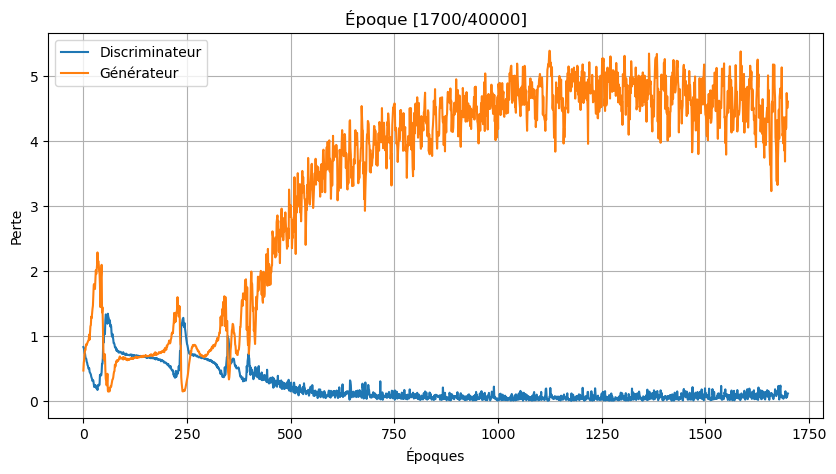

KeyboardInterrupt: 

In [9]:
for epoch in range(num_epochs):
    # Génération des données réelles avec bruit
    real_inputs = generate_batch_sine_waves(batch_size, seq_len, noise_std=noise)
    real_inputs = torch.tensor(real_inputs, dtype=torch.float32).to(device)

    # Génération des données factices
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_inputs = generator(z)

    # Entraînement du discriminateur
    optimizer_D.zero_grad()
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    output_real = discriminator(real_inputs)
    loss_real = criterion(output_real, real_labels)

    output_fake = discriminator(fake_inputs.detach())
    loss_fake = criterion(output_fake, fake_labels)

    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer_D.step()

    # Entraînement du générateur
    optimizer_G.zero_grad()
    fake_labels = torch.ones(batch_size, 1).to(device)  # Le générateur veut que le discriminateur pense que c'est réel
    output = discriminator(fake_inputs)
    loss_G = criterion(output, fake_labels)
    loss_G.backward()
    optimizer_G.step()

    # Stocker les pertes pour affichage
    losses_D.append(loss_D.item())
    losses_G.append(loss_G.item())

    if (epoch + 1) % 10000 == 0:
        noise /= 1.5

    # Affichage des pertes toutes les 10 époques
    if (epoch + 1) % 100 == 0:
        clear_output(wait=True)  # Efface le contenu précédent de la cellule
        
        # Affichage des pertes
        plt.figure(figsize=(10,5))
        plt.plot(losses_D, label="Discriminateur")
        plt.plot(losses_G, label="Générateur")
        plt.xlabel("Époques")
        plt.ylabel("Perte")
        plt.title(f"Époque [{epoch + 1}/{num_epochs}]")
        plt.legend()
        plt.grid()
        plt.show()

# Test affichage

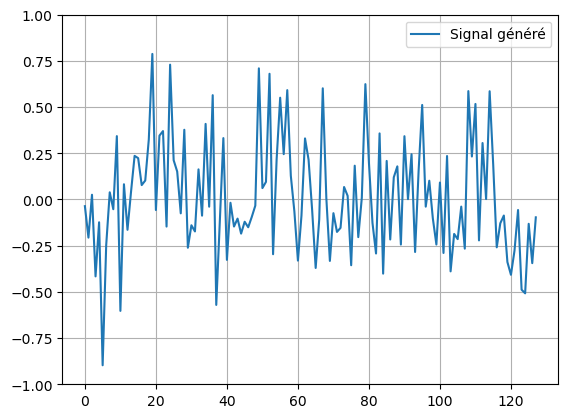

In [10]:
# Génération d'un signal réel
# real_signal = generate_batch_sine_waves(1, seq_len, noise_std=noise).reshape(seq_len)

# Génération d'un signal factice
z = torch.randn(1, latent_dim).to(device)
generated_signal = generator(z).detach().cpu().numpy().reshape(seq_len)

# Affichage du signal réel
# plt.plot(real_signal, label='Signal réel')

# Affichage du signal généré
plt.plot(generated_signal, label='Signal généré')
# plt.title("Signal réel/généré")
plt.ylim(-1, 1)  # Limites de l'axe y entre -1 et 1
plt.legend()
plt.grid()
plt.show()


# Sauvegarde du modèle

In [ ]:
save_dir = "model_saves"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
# Sauvegarde du générateur
torch.save(generator.state_dict(), os.path.join(save_dir, 'simple_sinus_generator.pth'))

# Sauvegarde du discriminateur
torch.save(discriminator.state_dict(), os.path.join(save_dir, 'simple_sinus_discriminator.pth'))

print("Les modèles ont été sauvegardés avec succès.")

# Sauvegarder des signaux

In [ ]:
save_dir = "sinus_simple"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
num_signals = 1000

for i in range(num_signals):
    z = torch.randn(1, latent_dim).to(device)
    generated_signal = generator(z).detach().cpu().numpy().reshape(seq_len)
    
    # Sauvegarder chaque signal dans un fichier .npy
    np.save(f'sinus_simple/signal_{i}.npy', generated_signal)

print(f"{num_signals} signaux ont été sauvegardés.")